# Линейная алгебра и её приложения в многомерной статистике
## Практикум 2. Кластеризация методом k-means
*Алла Тамбовцева*

### Подготовка к работе

В этом практикуме мы продолжим работать с данными по районам Балтимора из файла `Baltimore_data.csv`. Только вместо иерархической кластеризации воспользуемся методом k-means (однако сначала вспомним, как выглядела дендрограмма, чтобы выбрать число кластеров $k$ для k-means).

В файле `Baltimore_data.csv` собраны показатели, которые можно считать характеристиками благополучия района, в том числе с точки зрения покупки в этом районе жилья:

* `CSA2010`: название укрупненного района, по которому ведётся сбор статистических данных (*Community Statistical Area*), в соответствии с делением в 2010 году;
* `trees17`: процент деревьев в районе по состоянию на 2017 год (подробнее [здесь](https://data.baltimorecity.gov/maps/e8b7beca0fd649b1a77c58fafc4658a9/about));
* `racdiv21`: индекс расового/этнического разнообразия за 2021 год, более высокие значения – более высокое разнообразие (подробнее [здесь](https://data.baltimorecity.gov/maps/d588f7de06cf4815951e105bb8a390b1/about));
* `viol21`: число тяжких преступлений на 1000 жителей в 2021 году, включает число убийств, изнасилований, нападения, грабежи (подробнее [здесь](https://data.baltimorecity.gov/maps/ab03385abf3b4f50aec0b090caa8877a/about));
* `salepr19`: медианная цена продажи жилья в районе за 2019 год.

Импортируем необходимые библиотеки и функции:

* библиотека `pandas` для работы с таблицами;
* функции `linkage`, `dendrogram`, `cut_tree` из набора `hierarchy` модуля `cluster` библиотеки `scipy` для иерархического кластерного анализа;
* функцию `KMeans` из модуля `cluster` библиотеки `sklearn` для реализации кластерного анализа методом k-means. 

In [1]:
import pandas as pd

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, distance
from sklearn.cluster import KMeans

Если библиотека `sklearn` не установлена (ошибка *no module...*), её нужно установить через `pip`:

    !pip install sklearn
    
Загрузим данные из файла и сразу вынесем столбец с названиями районов `CSA2010` в названия строк, добавив аргумент `index_col`:

In [2]:
df = pd.read_csv("Baltimore/Baltimore_data.csv", index_col = "CSA2010")

Удалим ненужный столбец `Unnamed: 0`:

In [3]:
df = df.drop(columns = ["Unnamed: 0"])

Выполним центрирование и нормирование данных (ранее выполняли, подробнее – см. практикум 1):

In [4]:
to_clust = (df - df.mean()) / df.std()

### Вспоминаем иерархический кластерный анализ и выбираем число кластеров

Реализуем иерархический кластерный анализ, выбрав метод Варда в качестве метода агрегирования (Python сам выберет подходящее расстояние – квадрат евклидова) и построим дедрограмму: 

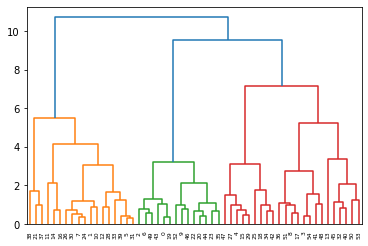

In [6]:
hc = linkage(to_clust, method = "ward")
dendrogram(hc);

В прошлый раз мы остановились на трёх кластерах. Воспользуемся функцией `cut_tree()`, чтобы «разрезать» дендрограмму на три ветки и получить метки кластеров от 0 до 2:

In [7]:
# подробнее про reshape() – см практикум 1

clusters_ward = cut_tree(hc, n_clusters = 3).reshape(-1, )
print(clusters_ward)

[0 1 0 2 2 1 0 1 2 0 1 1 1 2 1 2 1 2 2 0 0 1 0 0 1 2 1 2 1 2 1 1 2 1 2 0 2
 1 1 1 2 2 2 0 0 2 0 2 2 0 2 2 0 2 2]


**Важно:** нет гарантиии, что Python занумерует кластеры ровно так же, как на дендрограмме, слева направо (самый левый кластер – номер 0, самый правый – номер 2), поэтому при оценке результатов или сравнении разных способов кластеризации стоит ориентироваться не на номера групп, а на то, какие наблюдения туда входят и на то, похож ли состав групп в разных вариантах деления на кластеры).

### Реализуем кластеризацию методом k-means

Теперь реализуем кластерный анализ методом k-means с числом кластеров $k=3$. Так как на первом шаге алгоритм распределяет наблюдения на кластеры случайно (точнее, случайно «расставляет» центроиды и на основе близости к ним относит наблюдения к группам), для воспроизводимости результатов зафиксируем стартовую точку алгоритма `random_state`:

In [8]:
# random_state – любое целое неотрицательное число
# если все укажем 1234, результаты должны получиться одинаковыми

kmeans = KMeans(n_clusters=3, random_state=1234).fit(to_clust)

**Поянения к коду.** Функция `KMeans()` создаёт объект класса `sklearn.cluster._kmeans.KMeans`, на него можно смотреть как на хранилище результатов, из которого можно извлечь отдельные элементы, например, метки кластеров, координаты центроидов, число итераций, которое потребовалось для получения итогового деления на группы. Часть кода `KMeans(n_clusters=3, random_state=1234)` резервирует место под «пустое» хранилище для результатов деления на три кластера, а метод `.fit()` применяет алгоритм кластеризации к данным `to_clust`. 

Для примера запросим координаты центроидов (окончательные центры кластеры, которые получились по итогам деления на группы) – их должно быть три:

In [9]:
# три центра, пространство четырехмерное – четыре показателя (столбца) на входе
# три массива из четырех значений

kmeans.cluster_centers_

array([[-0.31873547, -0.87866307,  0.70297807, -0.83827786],
       [-0.70183636,  0.89607088,  0.10880749,  0.39928047],
       [ 1.1406391 , -0.01945579, -0.90728975,  0.49064415]])

Теперь запросим метки кластеров:

In [10]:
clusters_kmeans = kmeans.labels_
print(clusters_kmeans)

[0 2 0 1 1 2 0 2 1 0 2 2 0 1 2 1 2 1 1 0 0 2 0 0 2 1 2 1 2 1 2 2 0 2 1 0 1
 2 2 2 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1]


Если мы сравним метки кластеров с тем, что было получено ранее по результатом иерархической кластеризации методом Варда, мы увидим, что они разные:

In [11]:
print(clusters_ward)
print(clusters_kmeans)

[0 1 0 2 2 1 0 1 2 0 1 1 1 2 1 2 1 2 2 0 0 1 0 0 1 2 1 2 1 2 1 1 2 1 2 0 2
 1 1 1 2 2 2 0 0 2 0 2 2 0 2 2 0 2 2]
[0 2 0 1 1 2 0 2 1 0 2 2 0 1 2 1 2 1 1 0 0 2 0 0 2 1 2 1 2 1 2 2 0 2 1 0 1
 2 2 2 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1]


Однако это не значит, что результаты кардинально отличаются, просто Python по-разному занумеровал кластеры в первом и втором случае. Для сравнения имеет смысл сохранить и те, и другие метки кластеров в исходный датафрейм, а затем отфильтровать соответствующие наблюдения и сравнить состав групп. 

Главный вопрос: зачем это делать, если считается, что метод k-means даёт более точные результаты? Не всегда более точный метод может дать понятные и интересные с содержательной точки зрения кластеры, так как не всегда деление на группы стоит основывать исключительно на средних значениях показателей.

### Сравниваем результаты иерархической кластеризации и кластеризации методом k-means

Добавим столбцы с метками кластеров в датафрейм `df` (в `to_clust` можно, но в `df` данные до стандартизации – более понятные):

In [12]:
df["ward"] =  clusters_ward
df["kmeans"] = clusters_kmeans

In [13]:
df.head()

,trees17,racdiv21,viol21,salepr19,ward,kmeans
CSA2010,,,,,,
Allendale/Irvington/S. Hilton,32.372913,24.604789,17.264634,77250.0,0,0
Beechfield/Ten Hills/West Hills,48.696974,52.412494,11.007200,149000.0,1,2
Belair-Edison,20.827125,23.826836,16.837918,89758.0,0,0
Brooklyn/Curtis Bay/Hawkins Point,14.631858,80.860745,18.028044,57000.0,2,1
Canton,12.516619,40.504514,6.796941,275000.0,2,1


Отфильтруем строки, соответствующие каждому кластеру, по итогам иерархической кластеризации:

In [14]:
cluster0_ward = df[df["ward"] == 0]
cluster1_ward = df[df["ward"] == 1]
cluster2_ward = df[df["ward"] == 2]

Посмотрим на районы в кластерах 0, 1 и 2:

In [15]:
# .index, потому что названия районов сохранены как названия строк
# sorted() – сортируем по алфавиту для удобства

print("0", sorted(cluster0_ward.index))
print("1", sorted(cluster1_ward.index))
print("2", sorted(cluster2_ward.index))

0 ['Allendale/Irvington/S. Hilton', 'Belair-Edison', 'Cherry Hill', 'Clifton-Berea', 'Greater Govans', 'Greater Mondawmin', 'Greater Rosemont', 'Greenmount East', 'Midway/Coldstream', 'Penn North/Reservoir Hill', 'Pimlico/Arlington/Hilltop', 'Sandtown-Winchester/Harlem Park', 'Southern Park Heights', 'Upton/Druid Heights']
1 ['Beechfield/Ten Hills/West Hills', 'Cedonia/Frankford', 'Chinquapin Park/Belvedere', 'Cross-Country/Cheswolde', 'Dickeyville/Franklintown', 'Dorchester/Ashburton', 'Edmondson Village', 'Forest Park/Walbrook', 'Greater Roland Park/Poplar Hill', 'Hamilton', 'Harford/Echodale', 'Howard Park/West Arlington', 'Lauraville', 'Loch Raven', 'Medfield/Hampden/Woodberry/Remington', 'Mount Washington/Coldspring', 'North Baltimore/Guilford/Homeland', 'Northwood']
2 ['Brooklyn/Curtis Bay/Hawkins Point', 'Canton', 'Claremont/Armistead', 'Downtown/Seton Hill', 'Fells Point', 'Glen-Fallstaff', 'Greater Charles Village/Barclay', 'Harbor East/Little Italy', 'Highlandtown', 'Inner Ha

Проделаем то же для результатов k-means:

In [16]:
cluster0_kmeans = df[df["kmeans"] == 0]
cluster1_kmeans = df[df["kmeans"] == 1]
cluster2_kmeans = df[df["kmeans"] == 2]

print("0", sorted(cluster0_kmeans.index))
print("1", sorted(cluster1_kmeans.index))
print("2", sorted(cluster2_kmeans.index))

0 ['Allendale/Irvington/S. Hilton', 'Belair-Edison', 'Cherry Hill', 'Clifton-Berea', 'Dorchester/Ashburton', 'Greater Govans', 'Greater Mondawmin', 'Greater Rosemont', 'Greenmount East', 'Madison/East End', 'Midway/Coldstream', 'Oldtown/Middle East', 'Penn North/Reservoir Hill', 'Pimlico/Arlington/Hilltop', 'Poppleton/The Terraces/Hollins Market', 'Sandtown-Winchester/Harlem Park', 'Southern Park Heights', 'Southwest Baltimore', 'Upton/Druid Heights']
1 ['Brooklyn/Curtis Bay/Hawkins Point', 'Canton', 'Claremont/Armistead', 'Downtown/Seton Hill', 'Fells Point', 'Glen-Fallstaff', 'Greater Charles Village/Barclay', 'Harbor East/Little Italy', 'Highlandtown', 'Inner Harbor/Federal Hill', 'Midtown', 'Morrell Park/Violetville', 'Orangeville/East Highlandtown', 'Patterson Park North & East', 'South Baltimore', 'Southeastern', 'The Waverlies', 'Washington Village/Pigtown', 'Westport/Mount Winans/Lakeland']
2 ['Beechfield/Ten Hills/West Hills', 'Cedonia/Frankford', 'Chinquapin Park/Belvedere', 

При внимательном изучении списков можно установить, какие кластеры по итогам иерархической кластеризации и k-means получились наиболее похожими. Если смотреть на вопрос сравнения более формально, можем перейти к множествам и установить, какие кластеры содержат наибольшее число совпадений:

In [17]:
# превращаем в множества, множество - set

set0_ward = set(cluster0_ward.index)
set1_ward = set(cluster1_ward.index)
set2_ward = set(cluster2_ward.index)

set0_kmeans = set(cluster0_kmeans.index)
set1_kmeans = set(cluster1_kmeans.index)
set2_kmeans = set(cluster2_kmeans.index)

Сравниваем каждый кластер из `_ward` с каждым кластером из `_kmeans` (не кластеры `_ward` между собой и
не кластеры `_kmeans` между собой, кластеры в рамках одного метода не пересекаются), чтобы понять, какие кластеры похожи больше всего:

In [18]:
# метод .intersection() на множествах – пересечение
# len() – считаем число элементов в пересечении

# кластер 0 по методу Варда
print(len(set0_ward.intersection(set0_kmeans)))
print(len(set0_ward.intersection(set1_kmeans)))
print(len(set0_ward.intersection(set2_kmeans)))

14
0
0


Очевидно, что кластер 0 по итогам кластеризации методом Варда и кластер 0 по итогам k-means – самые похожие. Это не означает, что они полностью совпадают, просто совпадений больше всего. Проделаем эти операции для двух оставшихся кластеров, чтобы понимать, какие группы имеет смысл сравнивать при решении, результаты какой кластеризации нам подходят больше:

In [19]:
# кластер 1 по методу Варда 
# больше всего совпадений с кластером 2 по k-means

print(len(set1_ward.intersection(set0_kmeans)))
print(len(set1_ward.intersection(set1_kmeans)))
print(len(set1_ward.intersection(set2_kmeans)))

1
0
17


In [20]:
# кластер 2 по методу Варда 
# больше всего совпадений с кластером 1 по k-means

print(len(set2_ward.intersection(set0_kmeans)))
print(len(set2_ward.intersection(set1_kmeans)))
print(len(set2_ward.intersection(set2_kmeans)))

4
19
0


Итого, соотношение такое (примерно, кластеры не обязаны совпадать на 100%):

* кластер 0 по методу Варда – это кластер 0 по методу k-means;
* кластер 1 по методу Варда – это кластер 2 по методу k-means;
* кластер 2 по методу Варда – это кластер 1 по методу k-means.

Пользуясь теми же операциями над множествами, можем узнать, какие районы не входят в наиболее схожие кластеры по итогам той или иной кластеризации:

In [21]:
# метод .difference() – разность на множествах

# районы, которые присутствуют в кластере 0 по Варду и отсутствуют в кластере 0 по k-means
print(set0_ward.difference(set0_kmeans))

# районы, которые присутствуют в кластере 0 по k-means и отсутствуют в кластере 0 по Варду
print(set0_kmeans.difference(set0_ward))

set()
{'Dorchester/Ashburton', 'Madison/East End', 'Oldtown/Middle East', 'Southwest Baltimore', 'Poppleton/The Terraces/Hollins Market'}


In [22]:
# районы, которые присутствуют в кластере 1 по Варду и отсутствуют в кластере 2 по k-means
print(set1_ward.difference(set2_kmeans))

# районы, которые присутствуют в кластере 2 по k-means и отсутствуют в кластере 1 по Варду
print(set2_kmeans.difference(set1_ward))

{'Dorchester/Ashburton'}
set()


In [23]:
# районы, которые присутствуют в кластере 2 по Варду и отсутствуют в кластере 1 по k-means
print(set2_ward.difference(set1_kmeans))

# районы, которые присутствуют в кластере 1 по k-means и отсутствуют в кластере 2 по Варду
print(set1_kmeans.difference(set2_ward))

{'Madison/East End', 'Poppleton/The Terraces/Hollins Market', 'Southwest Baltimore', 'Oldtown/Middle East'}
set()


Итого: 

* При кластеризации методом k-means в первый кластер (кластер 0) были включены районы Poppleton/The Terraces/Hollins Market, Dorchester/Ashburton, Madison/East End, Oldtown/Middle East, Southwest Baltimore, при этом никакие районы, определённые в похожую группу методом Варда, выкинуты не были (пустое множество `set()`).

* При кластеризации методом k-means во второй кластер (кластер 1) никаких новых районов в эту группу добавлено не было, район Dorchester/Ashburton, который был в похожей группе методом Варда, выкинулся, а точнее, «перетёк» в кластер 0.

* При кластеризации методом k-means в третий кластер (кластер 2) тоже никаких новых районов в эту группу добавлено не было, районы Poppleton/The Terraces/Hollins Market, Madison/East End, Southwest Baltimore, Oldtown/Middle East благополучно «перетекли» в кластер 0.

О чём это говорит? О том, что глобальных различий между результатами кластеризации методом Варда и методом k-means нет (по идее, и не должно быть, потому что принципы работы методов схожи, оценивается удалённость до центроидов), однако, если нам важно получить содержательно обоснованные группы районов, нужно обратиться к вспомогательным данным и решить, куда всё-таки «перетекающие» районы определить. Руководствоваться можно информацией о социально-экономическом статусе районов, об их истории, о том, какое место они занимали на разных этапах урбанизации города, и так далее. И, конечно, можно нанести полученные результаты группировки на карту (одна карта для метода Варда, вторая – для k-means) и оценить, выглядит ли какое-то деление более логичным с точки зрения географического положения районов. 

**Дополнительно.** В качестве формального показателя сходства двух различных разделений на группы иногда используют [индекс Ранда](https://en.wikipedia.org/wiki/Rand_index) (*Rand index*) или его скорректированный вариант. Вычисление значения этого индекса подразумевает, что метки групп могут быть разными, поэтому без корректировки этот индекс характеризует долю наблюдений, которые одинаково оказались в одних и тех же/разных группах при разных группировках. Корректировка подразумевает сравнение наблюдаемых значений компонентов индекса с ожидаемыми на основе таблицы сопряжённости. Без корректировки индекс принимает значения от 0 до 1, где 1 соответствует высокой степени совпадений между двумя группировками. С корректировкой логика та же, но индекс иногда может получаться отрицательным. 

Для вычисления скорректированной версии индекса можно воспользоваться функцией `adjusted_rand_score()` из `sklearn`:

In [24]:
from sklearn.metrics.cluster import adjusted_rand_score

In [25]:
# вполне высокая согласованность, что ожидаемо
adjusted_rand_score(clusters_kmeans, clusters_ward) 

0.7450559911507973